In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from pathlib import Path
import re

# Modulation Measurement

Match the amplitude of the signal with the modulation.

## Visualize Data and Extract Amplitude

In [2]:
def signal_amplitude_from_csv(path, col="CH1(V)"):
    df = pd.read_csv(path)
    y = df[col].to_numpy()
    lo, hi = np.percentile(y, [1, 99])
    A = 0.5 * (hi - lo)
    offset = np.mean(y)
    return A, offset

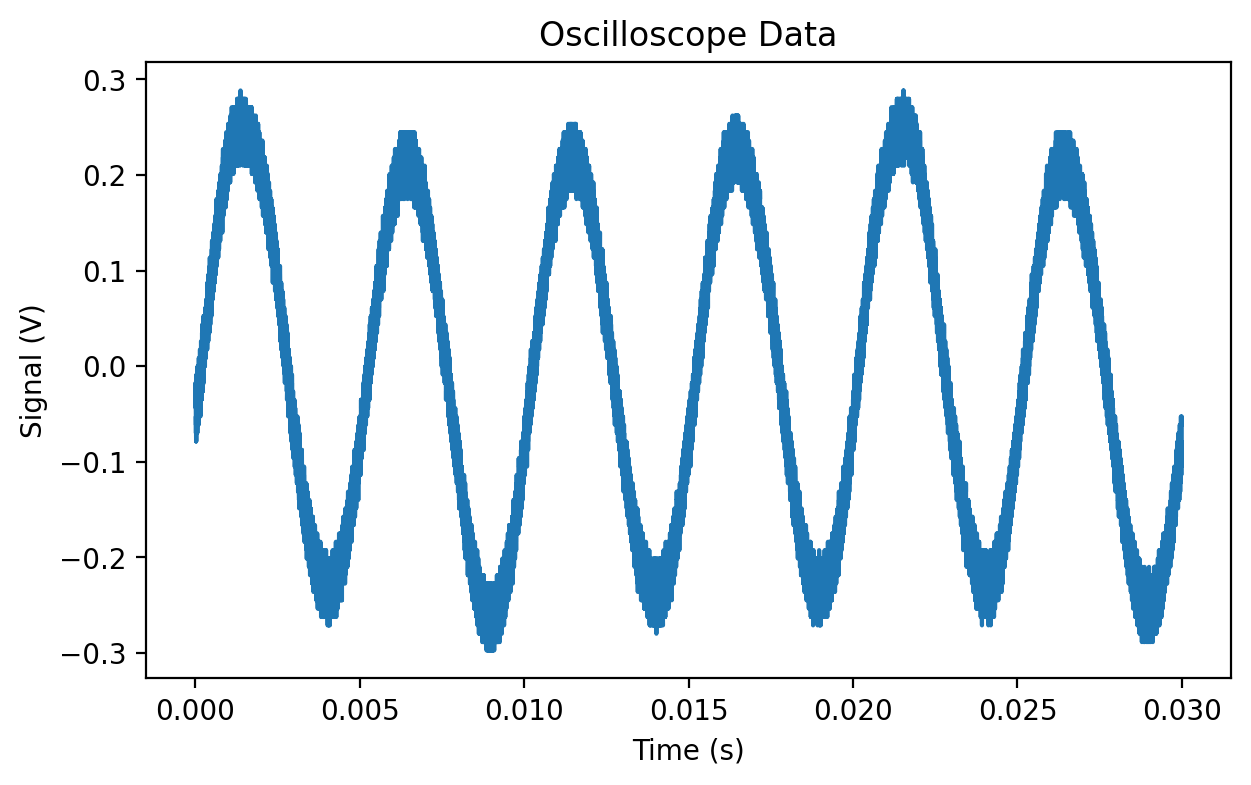

Amplitude [V]: 0.26225285
Offset [V]: -0.005489930609559002


In [3]:
test_amp = 500
cap = 300_000
data = pd.read_csv(f"mod/Rigol_{test_amp}.csv")
data["Time(s)"] = data["Time(s)"] + np.abs(data["Time(s)"].min()+1e-10)

plt.figure(figsize=(7,4), dpi=200)
plt.plot(data["Time(s)"][:cap], data["CH1(V)"][:cap])
plt.title("Oscilloscope Data")
plt.xlabel("Time (s)")
plt.ylabel("Signal (V)")
plt.show()

amplitude, offset = signal_amplitude_from_csv(f"mod/Rigol_{test_amp}.csv")
print("Amplitude [V]:", amplitude)
print("Offset [V]:", offset)

### Scan all data

In [4]:
def scan_modul_data_amp():
    rows = []
    for path in sorted(Path("mod").glob('Rigol_*.csv')):
        match = re.fullmatch(r'Rigol_(\d+)', path.stem)
        
        # Ignore non matching files
        if match is None:
            continue

        current_uA = int(match.group(1))
        amplitude, offset = signal_amplitude_from_csv(path)
        rows.append({'Current_uA': current_uA, 'Amplitude_V': amplitude, 'Offset_V': offset})

    return pd.DataFrame(rows).sort_values('Current_uA').reset_index(drop=True)

mod_amp_df = scan_modul_data_amp()
mod_amp_df

,Current_uA,Amplitude_V,Offset_V
0,10,0.043709,-0.007640
1,40,0.052451,-0.008741
2,60,0.061192,-0.006789
3,120,0.078676,-0.007209
4,170,0.122385,-0.006278
5,220,0.126756,-0.008427
6,280,0.148610,-0.008853
7,340,0.174835,-0.006529
8,390,0.205431,-0.005998
9,500,0.262253,-0.005490


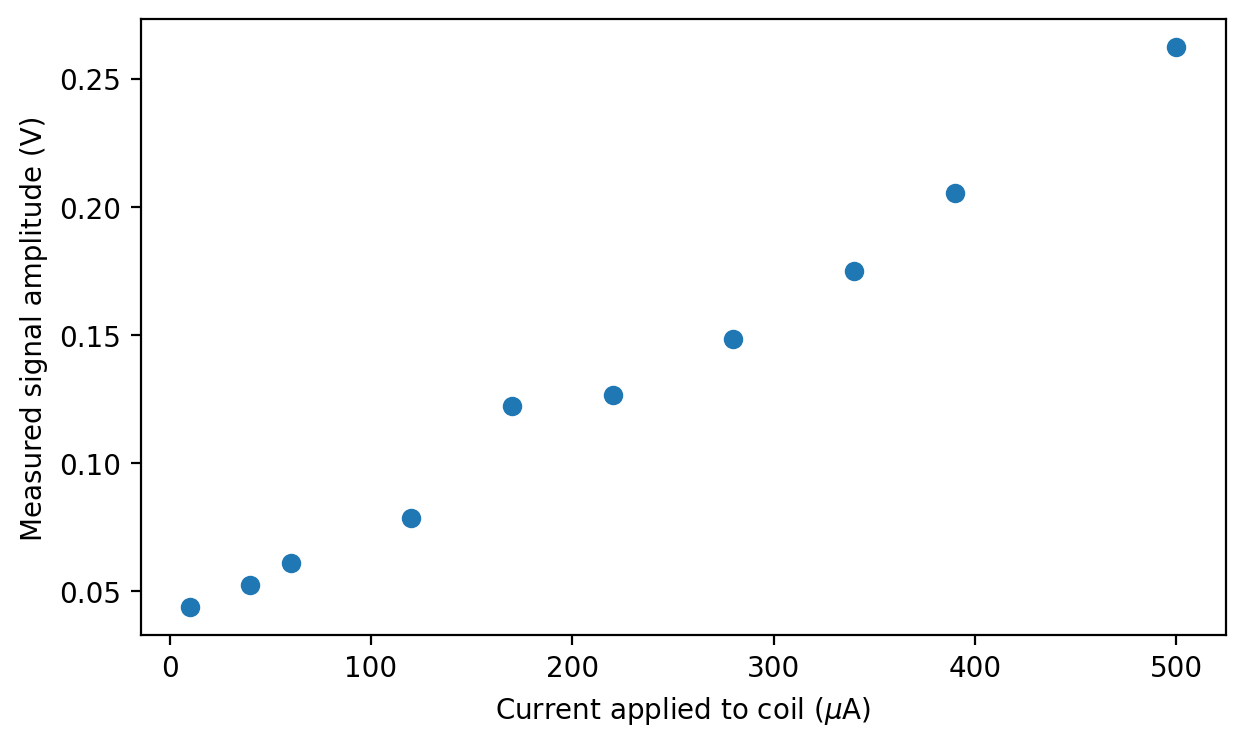

In [5]:
plt.figure(figsize=(7,4), dpi=200)
plt.scatter(mod_amp_df['Current_uA'], mod_amp_df['Amplitude_V'])
plt.xlabel(r"Current applied to coil ($\mu$A)")
plt.ylabel("Measured signal amplitude (V)")
plt.show()

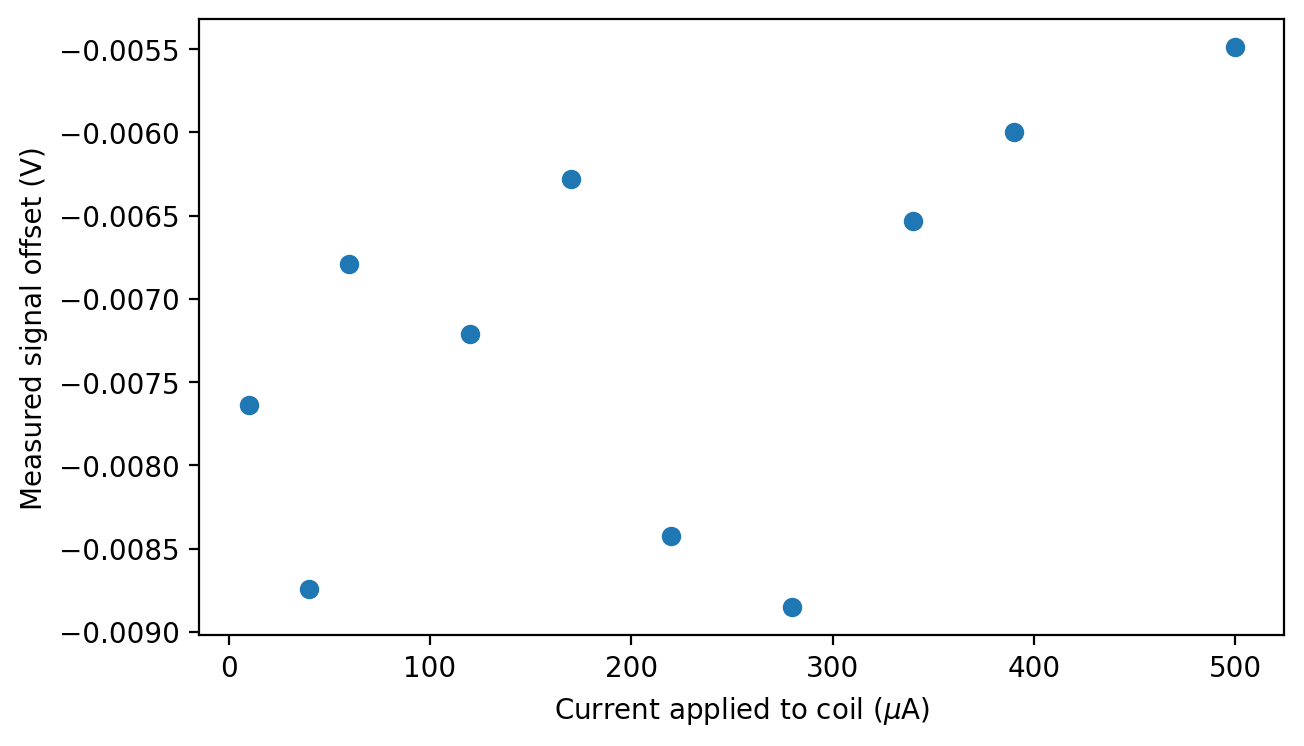

In [6]:
plt.figure(figsize=(7,4), dpi=200)
plt.scatter(mod_amp_df['Current_uA'], mod_amp_df['Offset_V'])
plt.xlabel(r"Current applied to coil ($\mu$A)")
plt.ylabel("Measured signal offset (V)")
plt.show()

## Trying with Frequency

In [7]:
def signal_spectrum_from_csv(path, time_col="Time(s)", signal_col="CH1(V)", fmin=None, fmax=None):
    df = pd.read_csv(path)

    t = df[time_col].to_numpy()
    y = df[signal_col].to_numpy()

    # Remove DC offset
    y = y - np.mean(y)

    # Sampling rate from time column
    dt = np.mean(np.diff(t))
    fs = 1 / dt

    # FFT
    Y = np.fft.rfft(y)
    freqs = np.fft.rfftfreq(len(y), dt)

    magnitude = np.abs(Y)

    # --- Apply frequency interval ---
    mask = np.ones_like(freqs, dtype=bool)
    if fmin is not None:
        mask &= freqs >= fmin
    if fmax is not None:
        mask &= freqs <= fmax

    freqs = freqs[mask]
    magnitude = magnitude[mask]

    return freqs, magnitude


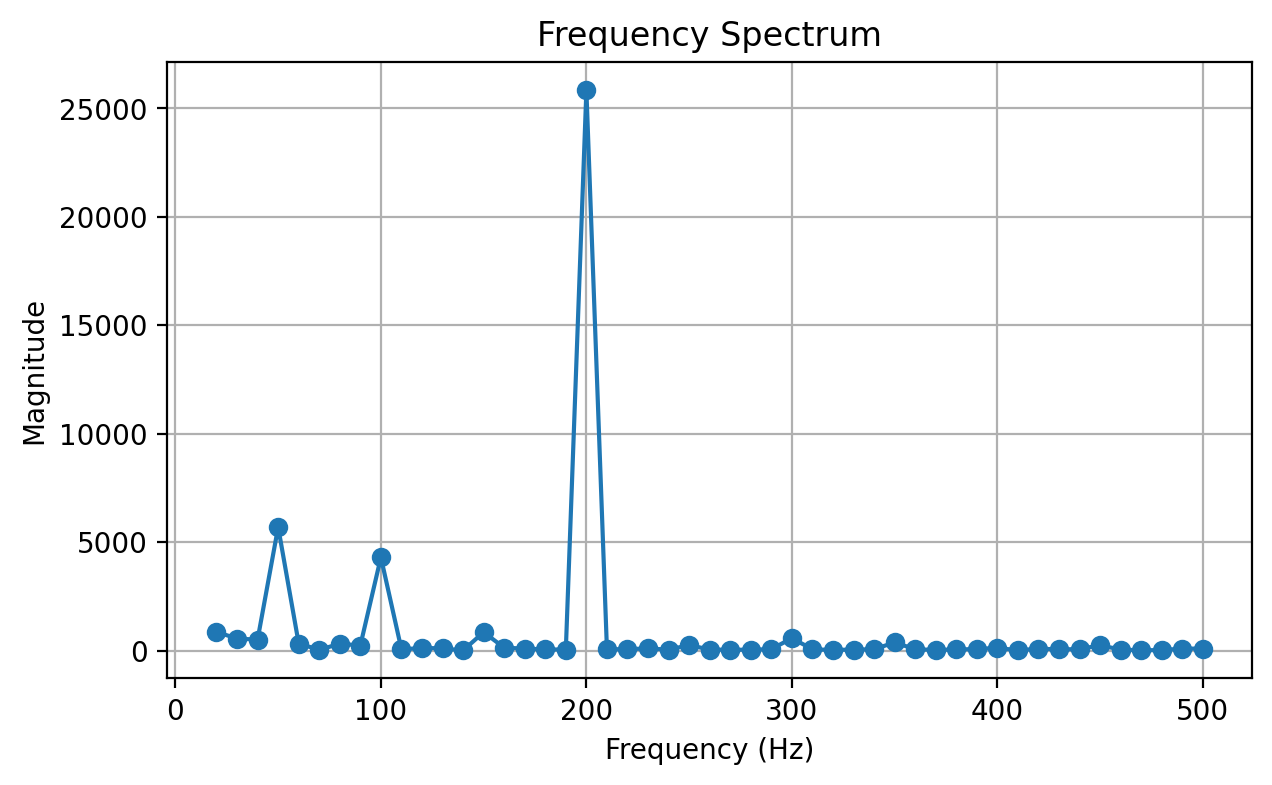

In [8]:
test_amp = '120'
freqs, magnitude = signal_spectrum_from_csv(f"mod/Rigol_{test_amp}.csv", fmin=10, fmax=500)

plt.figure(figsize=(7,4), dpi=200)
plt.plot(freqs, magnitude, marker='o')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Frequency Spectrum")
plt.grid(True)
plt.show()

In [9]:
freqs, magnitude

(array([ 19.99998,  29.99997,  39.99996,  49.99995,  59.99994,  69.99993,
         79.99992,  89.99991,  99.9999 , 109.99989, 119.99988, 129.99987,
        139.99986, 149.99985, 159.99984, 169.99983, 179.99982, 189.99981,
        199.9998 , 209.99979, 219.99978, 229.99977, 239.99976, 249.99975,
        259.99974, 269.99973, 279.99972, 289.99971, 299.9997 , 309.99969,
        319.99968, 329.99967, 339.99966, 349.99965, 359.99964, 369.99963,
        379.99962, 389.99961, 399.9996 , 409.99959, 419.99958, 429.99957,
        439.99956, 449.99955, 459.99954, 469.99953, 479.99952, 489.99951,
        499.9995 ]),
 array([8.63853333e+02, 5.49705770e+02, 5.06685453e+02, 5.69584948e+03,
        3.25767736e+02, 3.29879548e+01, 3.16734860e+02, 2.33877778e+02,
        4.30063754e+03, 5.46464666e+01, 1.20354239e+02, 1.03198901e+02,
        5.98578450e+00, 8.48306505e+02, 1.31769741e+02, 9.18045884e+01,
        5.24354054e+01, 4.76164489e+01, 2.58278488e+04, 6.03758200e+01,
        6.50322427e+01, 9.9

In [10]:
def scan_modul_data_freq():
    rows = []
    for path in sorted(Path("mod").glob('Rigol_*.csv')):
        match = re.fullmatch(r'Rigol_(\d+)', path.stem)
        
        # Ignore non matching files
        if match is None:
            continue

        current_uA = int(match.group(1))
        # max magnitude around 200Hz
        _, magnitude = signal_spectrum_from_csv(path, fmin=195, fmax=205)

        rows.append({'Current_uA': current_uA, 'Magnitude': np.max(magnitude)})

    return pd.DataFrame(rows).sort_values('Current_uA').reset_index(drop=True)

mod_freq_df = scan_modul_data_freq()
mod_freq_df

,Current_uA,Magnitude
0,10,2495.213961
1,40,9684.734271
2,60,14242.399921
3,120,25827.848752
4,170,38323.196113
5,220,48119.587758
6,280,60417.905306
7,340,73655.374208
8,390,87206.215603
9,500,118486.937076


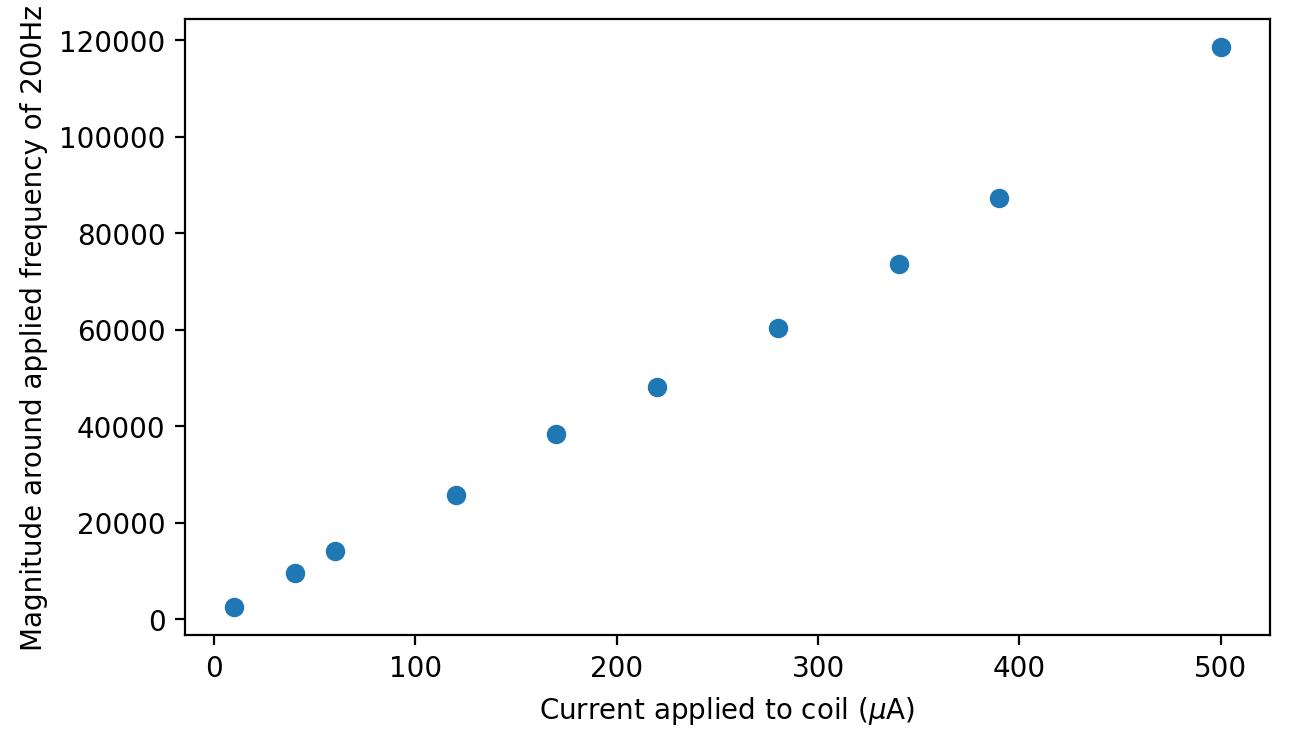

In [11]:
plt.figure(figsize=(7,4), dpi=200)
plt.scatter(mod_freq_df['Current_uA'], mod_freq_df['Magnitude'])
plt.xlabel(r"Current applied to coil ($\mu$A)")
plt.ylabel("Magnitude around applied frequency of 200Hz")
plt.show()

# Magnet Measurement

In this section we measure the signal response of the magnetometer to a magnet modelled as a cilinder.

## Theoretical Model

We model the stacked magnets as uniformly magnetized solid cylinders with axial magnetization along the $z$ axis. The total magnetic field is obtained by summing the contribution of each individual magnet.

The assumptions for this model are:

* Each magnet is a solid cylinder with radius ($R$) and thickness ($L$).
* The magnetization is uniform and oriented along the cylinder axis.
* The material is characterized by its remanent flux density (B_r).
* Magnets are stacked along the (z)-axis with a fixed spacing (air or plastic gap) between them.
* Magnetic interactions between magnets and external materials are neglected (superposition approximation).
* The field is computed only along the symmetry axis.


Using the equivalent surface magnetic charge model, an axially magnetized cylinder produces an axial field:

$$
B_z(z)=\frac{B_r}{2}
\left[
    \frac{z+L}{\sqrt{(z+L)^2+R^2}}
\frac{z}{\sqrt{z^2+R^2}}
\right]
$$

where (z) is measured from the lower face of the magnet.

This expression results from the difference between the fields produced by the two magnetized end faces.

A stack of $N$ magnets is modeled by placing each cylinder at its corresponding axial position and summing their contributions:

$$
B_{\text{total}}(z)=\sum_{i=1}^{N} B_i(z)
$$

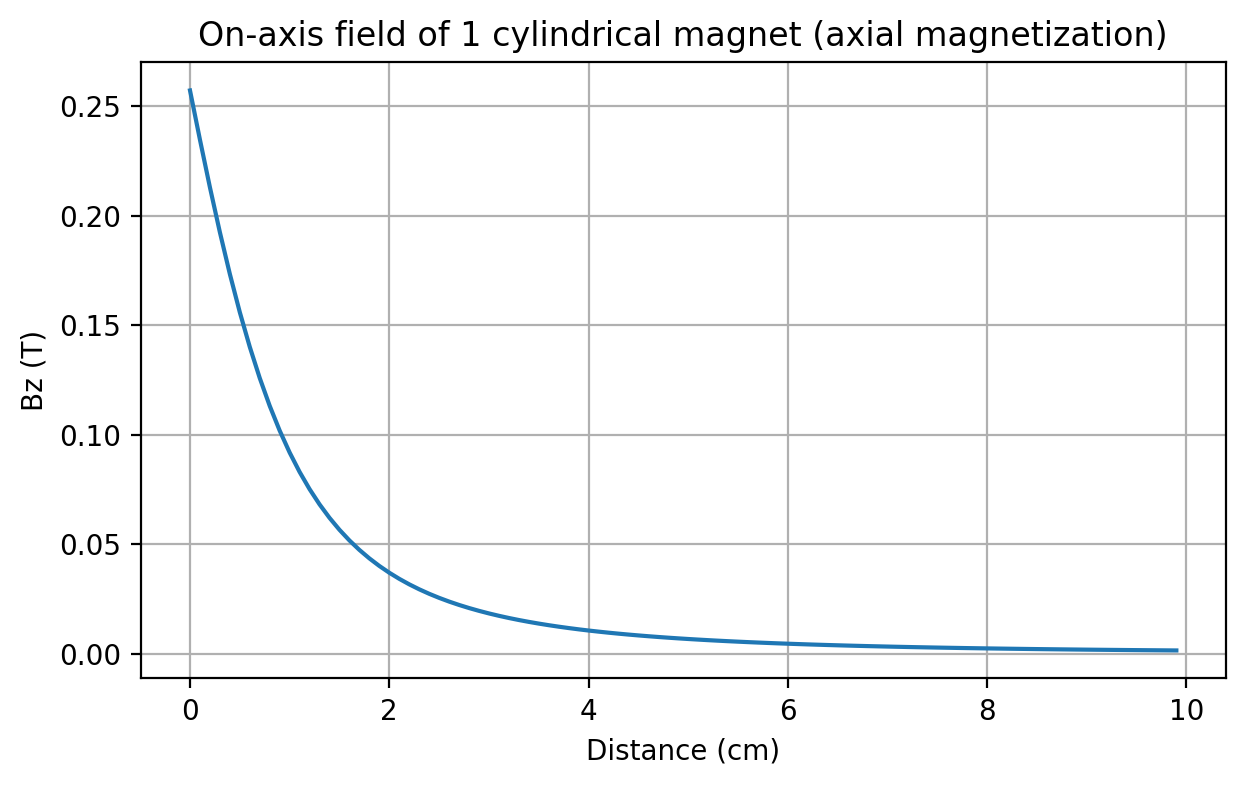

Magnetic Field at z=0 from the top of the magnet stack: 0.25711 T


In [12]:
def bz_cylinder_on_axis(z_m, z0_m, L_m, R_m, Br_T):
    """
    Axial magnetic flux density Bz (Tesla) of a uniformly axially-magnetized
    *solid cylindrical* permanent magnet, evaluated on the symmetry axis.

    Parameters
    ----------
    z_m : float or np.ndarray
        Observation position(s) along the z-axis [m].
    z0_m : float
        z-position of the magnet's *bottom face* [m].
    L_m : float
        Magnet thickness (height along z) [m].
    R_m : float
        Cylinder radius [m].
    Br_T : float
        Remanent flux density of the magnet material [T].

    Returns
    -------
    Bz_T : float or np.ndarray
        Axial magnetic flux density on-axis [T].
    """
    z = np.asarray(z_m) - z0_m  # coordinate relative to the magnet bottom face

    return 0.5 * Br_T * (
        (z + L_m) / np.sqrt((z + L_m)**2 + R_m**2)
        - z / np.sqrt(z**2 + R_m**2)
    )


def bz_stack_cylinders(distance_cm,
                       n_magnets=10,
                       gap_mm=0.5,
                       Br_T=1.45,
                       OD_mm=25.0,
                       thickness_mm=3.0,
                       z_reference="top"):
    """
    Total on-axis field (nT) from a stack of solid cylindrical magnets.

    The stack is modeled as N identical axially magnetized cylinders, separated
    by a constant gap. The total field is the linear superposition of each
    magnet's on-axis field.

    Parameters
    ----------
    distance_cm : float or np.ndarray
        Distance(s) from the chosen reference plane [cm].
    z_reference : {"top","bottom","center"}
        "top"    : distance measured from the stack top face outward (+z)
        "bottom" : distance measured from the stack bottom face outward (+z)
        "center" : distance measured from the stack geometric center (+z)
    OD_mm : float
        Outer diameter of the cylinder [mm] (used to compute radius).
    thickness_mm : float
        Thickness of each magnet [mm].
    gap_mm : float
        Gap between adjacent magnets [mm].

    Returns
    -------
    B_total_nT : float or np.ndarray
        Total axial field on the stack axis [nT].
    """
    # Geometry in meters
    R = (OD_mm / 2.0) * 1e-3
    L = thickness_mm * 1e-3
    gap = gap_mm * 1e-3

    pitch = L + gap
    total_height = n_magnets * L + (n_magnets - 1) * gap

    d = np.asarray(distance_cm, dtype=float) * 1e-2  # cm -> m

    # Define stack coordinates: first magnet bottom at z0_first, point at z_point
    if z_reference == "top":
        z0_first = 0.0
        z_point = total_height + d
    elif z_reference == "bottom":
        z0_first = 0.0
        z_point = d
    elif z_reference == "center":
        z0_first = -total_height / 2.0
        z_point = total_height / 2.0 + d
    else:
        raise ValueError("z_reference must be one of: 'top', 'bottom', 'center'")

    # Sum contributions (vectorized over z_point; loop only over magnets)
    B_total_T = np.zeros_like(z_point, dtype=float)
    for i in range(n_magnets):
        z0_i = z0_first + i * pitch
        B_total_T += bz_cylinder_on_axis(z_point, z0_i, L, R, Br_T)

    return B_total_T * 1e9  # Tesla -> nT


# ---- Example: plot field for a single cylinder referenced from the bottom face ----
X = np.arange(0, 10, 0.1)  # cm
B_z = bz_stack_cylinders(distance_cm=X,
                          n_magnets=10,
                          gap_mm=5.0,
                          Br_T=1.45,
                          OD_mm=25.0,
                          thickness_mm=3.0,
                          z_reference="top") * 1e-09  # nT -> T

plt.figure(figsize=(7,4), dpi=200)
plt.plot(X, B_z)
plt.xlabel("Distance (cm)")
plt.ylabel("Bz (T)")
plt.title("On-axis field of 1 cylindrical magnet (axial magnetization)")
plt.grid(True)
plt.show()

# ---- Example: field at 0 cm from the bottom of a 10-magnet stack (reported in Tesla) ----
B0_T = bz_stack_cylinders(distance_cm=0,
                          n_magnets=10,
                          gap_mm=5.0,
                          Br_T=1.45,
                          OD_mm=25.0,
                          thickness_mm=3.0,
                          z_reference="top") * 1e-9  # nT -> T
print("Magnetic Field at z=0 from the top of the magnet stack:", B0_T.round(5), "T")


## Experimental data

By moving the magnet in the z axis closer to the magnetometer, we found different signal data.

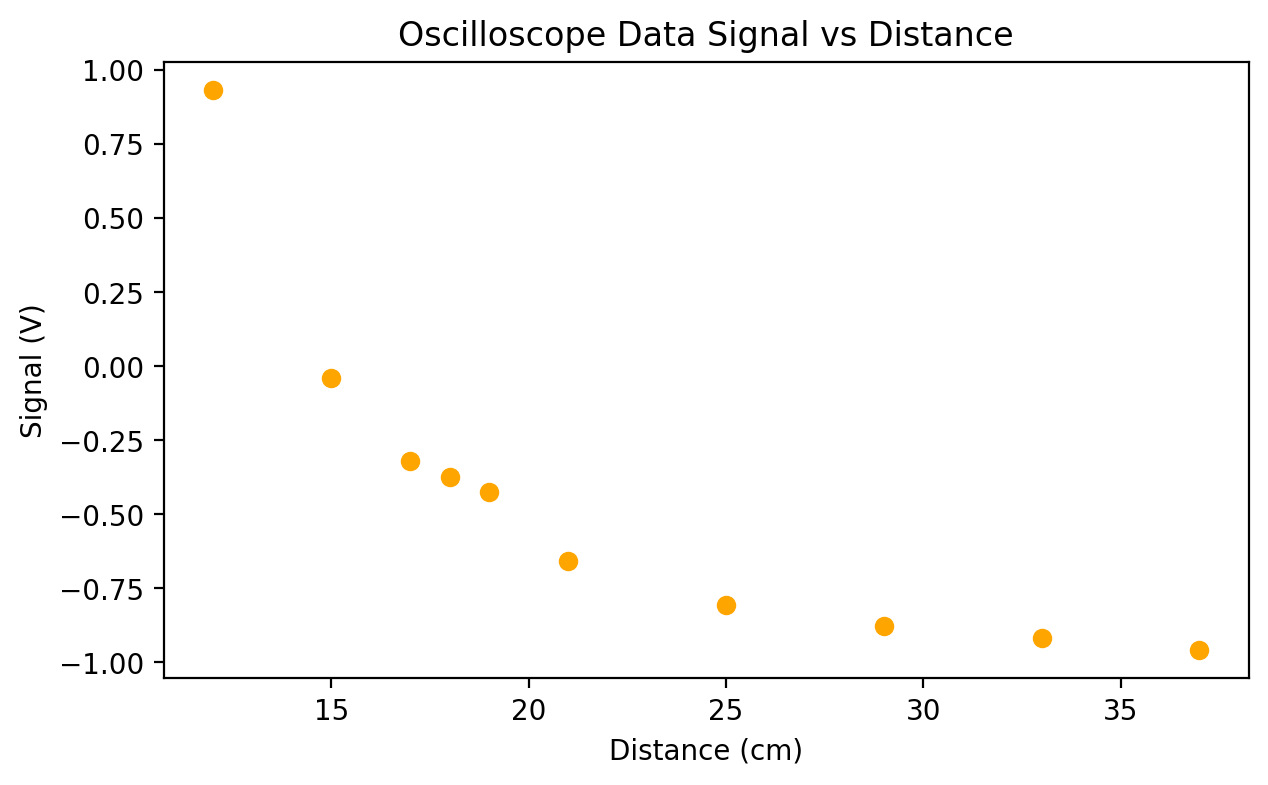

In [13]:
distances = [12,15,17,18,19,21,25,29,33,37]
means = []
for i in distances:
    data_t = pd.read_csv(f"im/RigolDSim{i}.csv")
    means.append(-data_t["CH1(V)"].mean())

plt.figure(figsize=(7,4), dpi=200)
plt.scatter(distances, means, color="orange")
plt.title("Oscilloscope Data Signal vs Distance")
plt.xlabel("Distance (cm)")
plt.ylabel("Signal (V)")
# plt.yscale('log')
plt.show()

## Adjusting the data

Now we adjust the measured data to find a relation between the signal and the magnetic field it corresponds to.

In [14]:
def calibrate_linear(dist_cm, volt, **model_kwargs):
    """
    Linear calibration of magnetometer voltage vs theoretical magnetic field.

    Fits a linear model:
        V = a * B + b

    Parameters
    ----------
    dist_cm : array-like
        Distances from the magnet stack [cm].
    volt : array-like
        Measured voltages from the magnetometer [V].
    model_kwargs : dict
        Parameters passed to the magnetic field model
        (e.g., gap_mm, Br_T, etc.).

    Returns
    -------
    dict
        a_V_per_nT : sensor gain [V/nT]
        b_V        : voltage offset [V]
        a_err      : uncertainty of gain
        b_err      : uncertainty of offset
    """

    dist_cm = np.asarray(dist_cm, dtype=float)
    volt = np.asarray(volt, dtype=float)

    # Compute theoretical magnetic field (nT) for each distance
    B_nT = np.array([bz_stack_cylinders(d, **model_kwargs) for d in dist_cm])

    # Linear model: V = a*B + b
    def V_model(B, a, b):
        return a * B + b

    # Fit model parameters
    (a, b), cov = curve_fit(V_model, B_nT, volt)
    a_err, b_err = np.sqrt(np.diag(cov))

    return {
        "a_V_per_nT": a,
        "b_V": b,
        "a_err": a_err,
        "b_err": b_err
    }
curve = calibrate_linear(distances, means, 
                         # Model Arguments
                         n_magnets=10, gap_mm=0.5, Br_T=1.45, OD_mm=25, thickness_mm=3, z_reference="top"
                         )
print(curve)

{'a_V_per_nT': np.float64(1.5609083391158716e-06), 'b_V': np.float64(-1.061564072828546), 'a_err': np.float64(3.665488982083981e-08), 'b_err': np.float64(0.019259868544106964)}


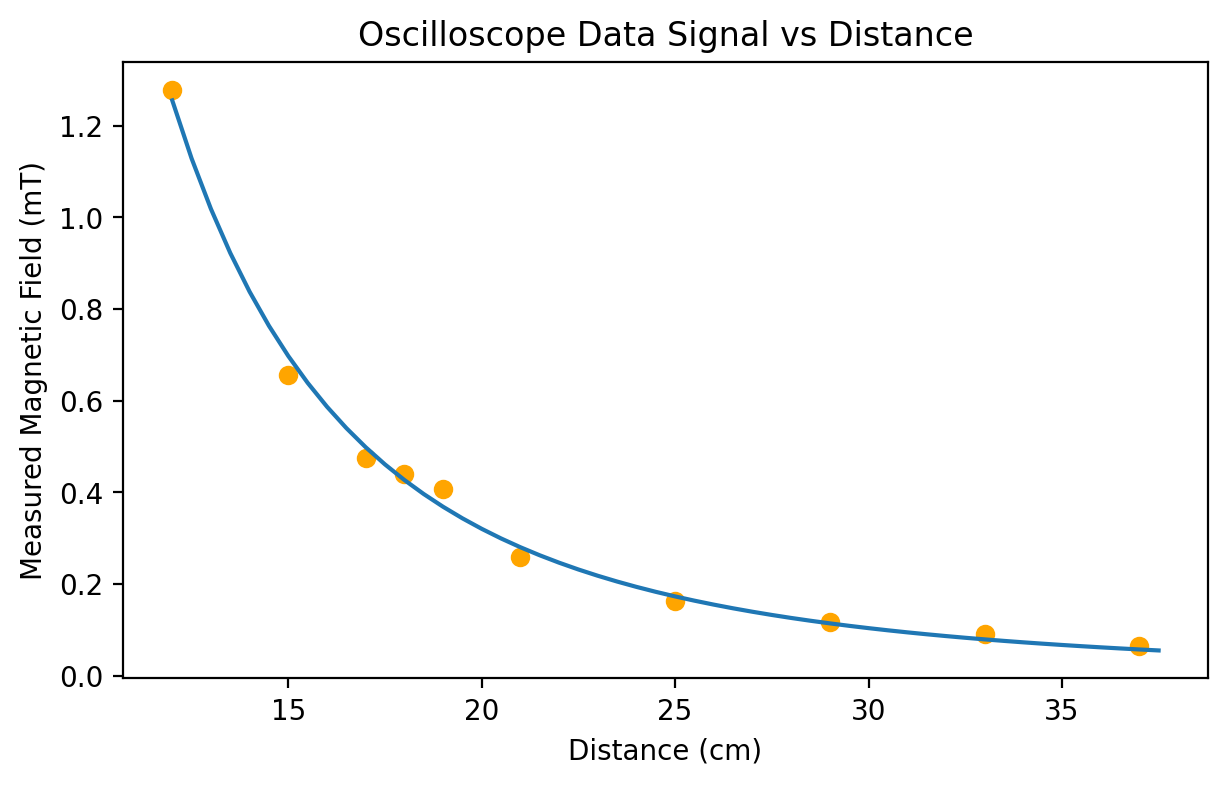

In [15]:
distances_full_range = np.arange(min(distances),max(distances)+1,0.5) 
theoretical_Bz = bz_stack_cylinders(distance_cm=distances_full_range,
                             n_magnets=10,
                             gap_mm=0.5,     
                             Br_T=1.45,      
                             OD_mm=25.0,
                             thickness_mm=3.0,
                             z_reference="top")

plt.figure(figsize=(7,4), dpi=200)
plt.plot(distances_full_range, theoretical_Bz *1e-6)
plt.scatter(distances, (np.array(means)-curve['b_V'])/curve['a_V_per_nT'] *1e-6, color="orange")
plt.title("Oscilloscope Data Signal vs Distance")
plt.xlabel("Distance (cm)")
plt.ylabel("Measured Magnetic Field (mT)")
# plt.yscale('log')
plt.show()

## Converting Measurements

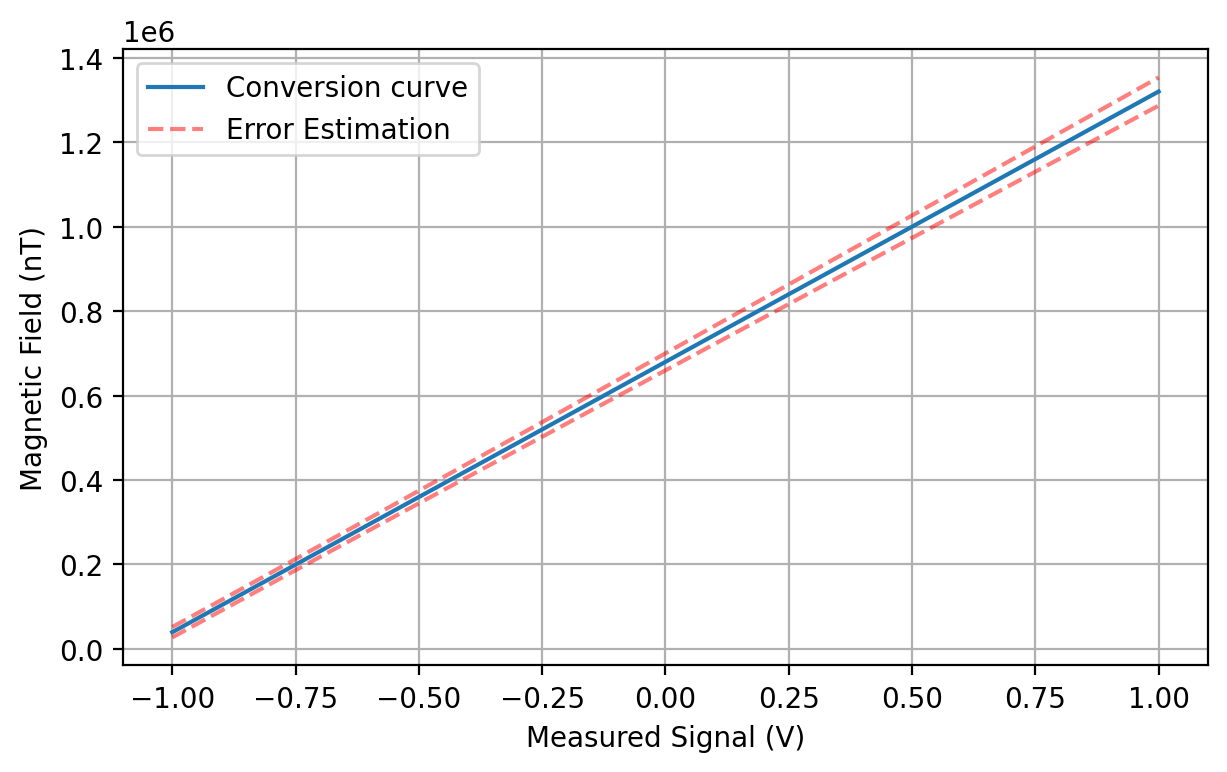

In [16]:
# Conversion function
def magnetometer_signal_to_magnetic_field(signal, curve):
    return (signal-curve['b_V'])/curve['a_V_per_nT'] # nT

# Error Estimation Function
def magnetometer_signal_to_magnetic_field_error(signal, curve, signal_err=0.0):
    a = curve['a_V_per_nT']
    b = curve['b_V']
    a_err = curve['a_err']
    b_err = curve['b_err']
    signal = np.asarray(signal, dtype=float)
    signal_err = np.asarray(signal_err, dtype=float)
    return np.sqrt((signal_err / a)**2 + (b_err / a)**2 + (((signal - b) * a_err) / (a**2))**2)

# Signal Relation
signal = np.linspace(-1,1,100)
magnetic_field = magnetometer_signal_to_magnetic_field(signal, curve)

# Error Estimation
magnetic_field_err = magnetometer_signal_to_magnetic_field_error(signal, curve)
sup_mf,inf_mf = magnetic_field + magnetic_field_err, magnetic_field - magnetic_field_err


plt.figure(figsize=(7,4), dpi=200)
plt.plot(signal, magnetic_field, label="Conversion curve")
plt.plot(signal, sup_mf, color='red', alpha=0.5, linestyle='--', label="Error Estimation")
plt.plot(signal, inf_mf, color='red', alpha=0.5, linestyle='--')
plt.xlabel("Measured Signal (V)")
plt.ylabel("Magnetic Field (nT)")
plt.grid()
plt.legend()
plt.show()